In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
"""
Load the data set we will be working with
"""

data_dir = 'Datasets'
dataset_name = 'BioTIME Study 213'

df = pd.read_csv(f'{data_dir}/study_213/top_5_213_linear.csv')
df.drop(columns = 'DATE', inplace = True)
df = (df - df.mean()) / df.std()
display(df)

,7058,8572,39601,8901,7730
0,1.432496,-0.138378,-0.594625,0.246337,-0.421221
1,1.378202,-0.152006,-0.594652,0.234287,-0.421238
2,1.323909,-0.165634,-0.594680,0.222237,-0.421254
3,1.269615,-0.179262,-0.594707,0.210186,-0.421270
4,1.215322,-0.192890,-0.594735,0.198136,-0.421287
...,...,...,...,...,...
16427,0.401515,-0.088686,-0.589972,0.349214,-0.421646
16428,0.190545,-0.214267,-0.550695,0.132939,-0.420266
16429,-0.020426,-0.339848,-0.511419,-0.083336,-0.418886
16430,-0.231396,-0.465429,-0.472142,-0.299611,-0.417506


In [3]:
"""
Set the parameters for the linear regression here
"""

# We will look at the last three values for each species and try to predict the next value using linear regression
lag = 2

expected = df.iloc[lag:, :]
display(expected)

,7058,8572,39601,8901,7730
2,1.323909,-0.165634,-0.594680,0.222237,-0.421254
3,1.269615,-0.179262,-0.594707,0.210186,-0.421270
4,1.215322,-0.192890,-0.594735,0.198136,-0.421287
5,1.161028,-0.206518,-0.594762,0.186086,-0.421303
6,1.106735,-0.220146,-0.594790,0.174036,-0.421319
...,...,...,...,...,...
16427,0.401515,-0.088686,-0.589972,0.349214,-0.421646
16428,0.190545,-0.214267,-0.550695,0.132939,-0.420266
16429,-0.020426,-0.339848,-0.511419,-0.083336,-0.418886
16430,-0.231396,-0.465429,-0.472142,-0.299611,-0.417506


In [4]:
def predict(index, species, df, lag):
    data = df.loc[index - lag : index - 1, species]

    y = data.to_numpy()
    x = np.arange(start = index - lag, stop = index)
    
    A = np.vstack([x, np.ones(len(x))]).T
    m, c = np.linalg.lstsq(A, y, rcond=None)[0]
    
    return m * index + c


In [5]:
predicted = np.array([[predict(index, species, df, lag) for index in range(lag, len(df))] for species in df.columns])

In [6]:
error = pd.DataFrame()

for i, column in enumerate(df.columns):
    error[column] = pd.Series((expected.to_numpy().T - predicted)[i])

display(error)

,7058,8572,39601,8901,7730
0,8.881784e-16,5.551115e-17,-2.220446e-16,-2.775558e-17,-1.665335e-16
1,-4.440892e-16,-5.551115e-17,1.110223e-16,1.387779e-16,3.330669e-16
2,-6.661338e-16,1.665335e-16,1.110223e-16,-1.665335e-16,2.220446e-16
3,2.220446e-16,-5.551115e-17,-1.110223e-16,2.498002e-16,-5.551115e-17
4,1.554312e-15,-1.110223e-16,-5.551115e-16,2.220446e-16,-4.440892e-16
...,...,...,...,...,...
16425,7.206541e-01,3.111170e-01,2.773541e-02,8.779590e-01,4.044059e-02
16426,-7.851711e-01,-3.167884e-01,3.283514e-02,-1.011231e+00,1.379863e-03
16427,-7.289308e-14,-3.687606e-13,-5.984102e-14,-1.535161e-13,-1.942890e-15
16428,5.211664e-13,2.280398e-13,-7.255307e-14,-3.561595e-13,-1.221245e-15


In [7]:
import torch
from torcheval.metrics.functional import r2_score

import statistics

np_error = error.to_numpy()
mse_loss = np.mean(np_error * np_error)
r2_loss = statistics.fmean([r2_score(torch.tensor(predicted[i]), torch.tensor(expected[o].tolist())) for i, o in enumerate(expected.columns)])
l1_loss = np.mean(np.abs(np_error))

print(f'MSE: {mse_loss:.4f}')
print(f'R2 Score: {r2_loss:.4f}')
print(f'MAE: {l1_loss:.4f}')

MSE: 0.4460
R2 Score: 0.5541
MAE: 0.0893


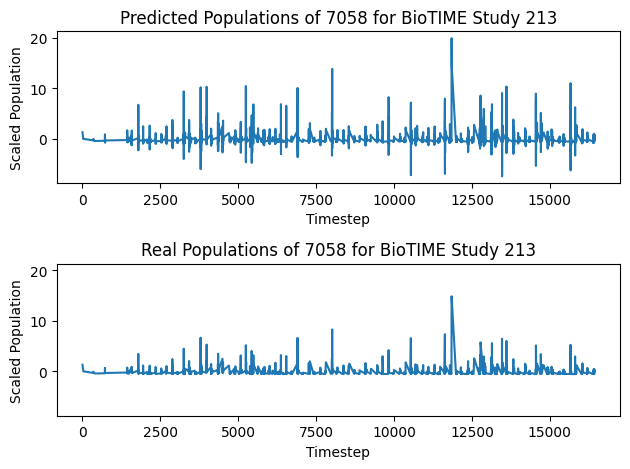

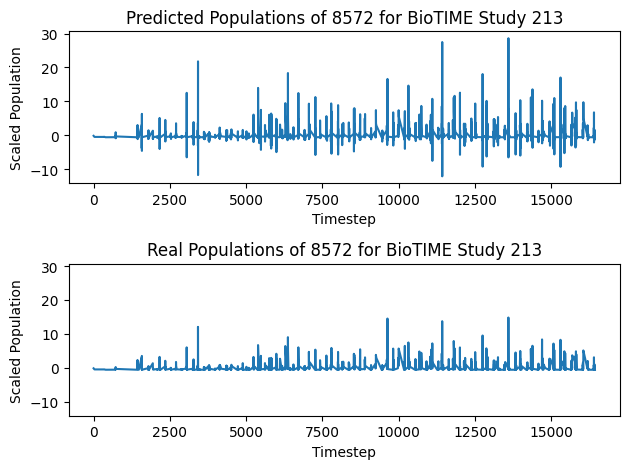

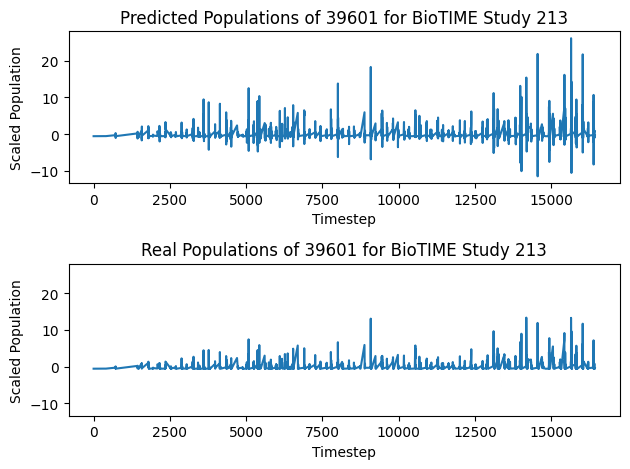

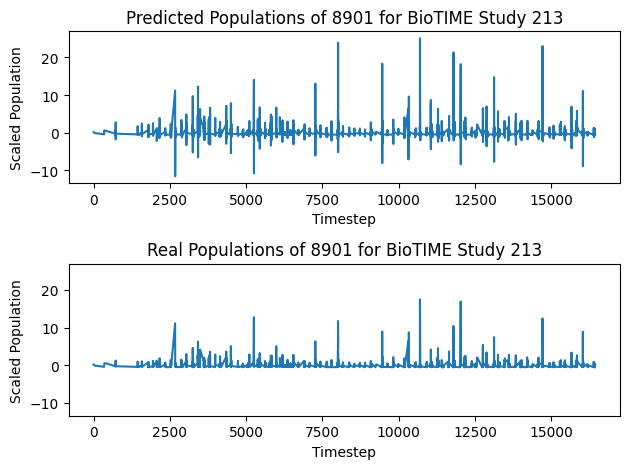

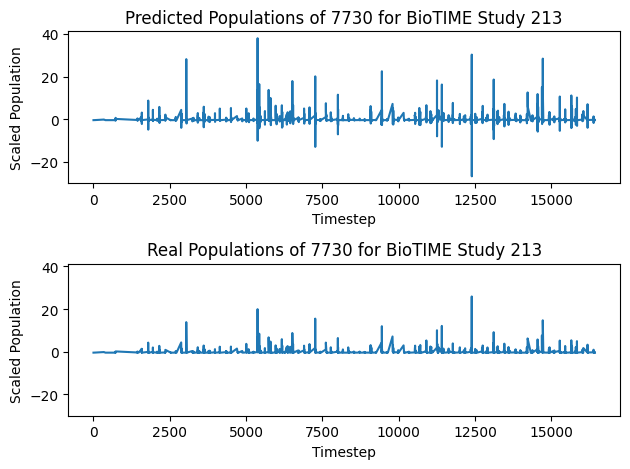

In [8]:
for i, s in enumerate(expected.columns):
    fig, (p, r) = plt.subplots(2, sharey = True)
    
    p.plot(range(1, len(predicted[i]) + 1), predicted[i])
    p.title.set_text(f'Predicted Populations of {s} for {dataset_name}')
    p.set_xlabel('Timestep')
    p.set_ylabel('Scaled Population')
    r.plot(range(1, len(predicted[i]) + 1), expected[s].tolist())
    r.title.set_text(f'Real Populations of {s} for {dataset_name}')
    r.set_xlabel('Timestep')
    r.set_ylabel('Scaled Population')
    plt.tight_layout()
    plt.show()